# Transformer复现
> 用pytorch 复现transformer

- toc: true 
- badges: true
- comments: true
- author: Bujie Xu
- categories: [NLP]

In [15]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

# 1.背景介绍

在处理序列问题上，RNN一直占据着主导地位。但是RNN有几个问题

- 不能并行化，因为RNN得每一个状态都依附于前一个状态。这就导致了不能构建很复杂得RNN模型。
- RNN对长序列得记忆能力有限。

Transformer就是用来解决上述两个问题的。Transofmer中的self-attention机制可以弥补长序列记忆问题，另外transformer完全舍弃了传统的RNN结构，这使得模型的并行化成为可能。

# 2.模型结构

传统的seq2seq模型由一个Encoder和一个Decoder构成，Encoder用于对输入序列编码，抽出有效信息，Decoder对已编码的信息进行解码，得到最终结果。Transformer也是由一个Encoder和一个Decoder构成。

In [5]:
# what's mask, what's memory
class EncoderDecoder(nn.Module):
    """
    标准的Encoder-Decoder结构。
    """
    def __init__ (self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.scr_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
    
    def forward(self, src, tgt, src_mask, tgt_mask):
        """
        Take in and process masked src and target sequences.
        """
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [6]:
class Generator(nn.Module):
    "定义linear+softmax层"
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

![](https://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png)

## Encoder和Decoder的实现

### Encoder

The encoder is composed of a stack of 
N
=
6
 identical layers.

In [8]:
def clones(module, N):
    "拷贝layer"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [9]:
class Encoder(nn.Module):
    "Transformer里的Encoder是由多层相同结构构成"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

在多头attention layer和FF layer之后都存在残差block，和layer normalization。

In [11]:
class LayerNorm(nn.Module):
    "构建LayerNorm层"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2*(x-mean)/(std + self.eps) + self.b_2

在Encoder的结构中由两个子结构
1. LayerNorm(x + Attention(x))
2. LayerNorm(x + FF(x))

两个子结构的输出都经过了LayerNorm。我们在Attenntion(x)和FF(x)之后分别加入dropout。

In [13]:
class SublayerConnection(nn.Module):
    """
    残差链接+layer norm。
    因为sublayer的两端都有layer norm。为了编程方便，我们把layer norm放在模型的开端
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))
        

每个Transformer block由两个sublayer构成。第一个sublayer是一个multihead self-attention， 第二个sublayer是一个简单的全连接层。

In [16]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
    
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### Decoder

In [17]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [18]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

在Decoder的mask里，为了防止模型可以直接看到预测值，我们将output embedding向右移动了一位。这使得模型在做预测时不会已知预测值。

In [19]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

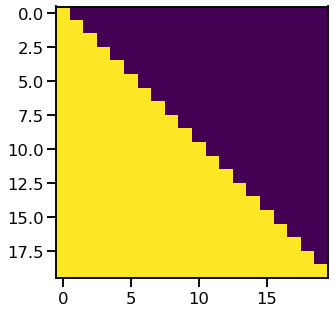

In [20]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

### Attention

![](images/attention1.PNG)

![Attention](https://nlp.seas.harvard.edu/images/the-annotated-transformer_33_0.png)

$$
Attention(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

In [23]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    # mask 
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn